In [1]:
import numpy as np
import pandas as pd
rng = np.random.default_rng(12345)

from lymph.models import Unilateral
from lymixture import LymphMixture
from lymixture.utils import binom_pmf, late_binomial, normalize

dataset = pd.read_csv('../../data/mixture_model_data_combined.csv', header = [0,1,2],)
dataset_staging = dataset.copy()
dataset_staging['tumor','1','t_stage'] = dataset_staging['tumor','1','t_stage'].replace([0,1,2], 'early')
dataset_staging['tumor','1','t_stage'] = dataset_staging['tumor','1','t_stage'].replace([3,4], 'late')
dataset_staging = dataset_staging[~(dataset_staging['tumor']['1']['subsite'].str.startswith(('C00.4')))]

In [2]:
dataset_staging_main_groups = dataset_staging.copy()

# Reduce to only main subsite
dataset_staging_main_groups.loc[:, ('tumor', '1', 'subsite')] = (
    dataset_staging_main_groups.loc[:, ('tumor', '1', 'subsite')].str.replace(r'\..*', '', regex=True)
)

dataset_staging_main_groups['tumor']['1']['subsite'].value_counts()


subsite
C09    452
C12    227
C01    212
C10    169
C13    165
C02    158
C04     99
C05     61
C06     46
C03     45
Name: count, dtype: int64

In [6]:
graph = {
    ("tumor", "T"): ["I", "II", "III", "IV", "V"],
    ("lnl", "I"): ["II"],
    ("lnl", "II"): ["III"],
    ("lnl", "III"): ["IV"],
    ("lnl", "IV"): ["V"],
    ("lnl", "V"): [],
}

num_components = 3

mixture = LymphMixture(
    model_cls=Unilateral,
    model_kwargs={"graph_dict": graph},
    num_components=num_components,
    universal_p= False
)
mixture.load_patient_data(
    dataset_staging_main_groups,
    split_by=("tumor", "1", "subsite"),
    mapping=lambda x: x,
)


In [7]:
mixture.set_distribution("early", binom_pmf(np.arange(11), 10, 0.3))
mixture.set_distribution("late", late_binomial)
mixture.set_modality("diagnostic_consensus", 1., 1.)

In [8]:
mixture.subgroups.keys()

dict_keys(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C09', 'C10', 'C12', 'C13'])

Initialize random model parameters and latent variables/responsibilities.

In [9]:
from lymixture.em import expectation, maximization

params = {k: rng.uniform() for k in mixture.get_params()}
# params = {'0_TtoI_spread': 0.03628421062998108,
#  '0_TtoII_spread': 0.5694201218237662,
#  '0_TtoIII_spread': 0.024089493035651215,
#  '0_TtoIV_spread': 0.007991459519587112,
#  '0_TtoV_spread': 0.017450914601597076,
#  '0_ItoII_spread': 0.9999338930386481,
#  '0_IItoIII_spread': 0.15688650559245462,
#  '0_IIItoIV_spread': 0.21661193269679863,
#  '0_IVtoV_spread': 0.19104551579914725,
#  '0_C01_coef': 0.8691374019087204,
#  '0_C02_coef': 0.23708168027769252,
#  '0_C03_coef': 6.610696135189607e-05,
#  '0_C04_coef': 0.08631478356033348,
#  '0_C05_coef': 0.4127616455079167,
#  '0_C06_coef': 0.06420688335904512,
#  '0_C09_coef': 0.7059220652487983,
#  '0_C10_coef': 0.42406400369233466,
#  '0_C12_coef': 0.10152419687718993,
#  '0_C13_coef': 0.07816483651718796,
#  '1_TtoI_spread': 0.07414947628617403,
#  '1_TtoII_spread': 0.030268693680739776,
#  '1_TtoIII_spread': 0.021091202610107912,
#  '1_TtoIV_spread': 0.0055157383008690485,
#  '1_TtoV_spread': 0.00022366393680736492,
#  '1_ItoII_spread': 0.2583329498611006,
#  '1_IItoIII_spread': 0.06424572410183653,
#  '1_IIItoIV_spread': 6.610696135189607e-05,
#  '1_IVtoV_spread': 6.610696135189607e-05,
#  '1_C01_coef': 0.04420594277655354,
#  '1_C02_coef': 0.6480373436889144,
#  '1_C03_coef': 0.9998677860772962,
#  '1_C04_coef': 0.8652739492027672,
#  '1_C05_coef': 0.5871722475307314,
#  '1_C06_coef': 0.935727009679603,
#  '1_C09_coef': 0.11472405138393393,
#  '1_C10_coef': 0.23564700655269388,
#  '1_C12_coef': 1.447492052385202e-05,
#  '1_C13_coef': 2.1718230423004026e-05,
#  '2_TtoI_spread': 0.010073344388471975,
#  '2_TtoII_spread': 0.24376525135229166,
#  '2_TtoIII_spread': 0.12926227198554394,
#  '2_TtoIV_spread': 0.04242036182094629,
#  '2_TtoV_spread': 0.031015599151049643,
#  '2_ItoII_spread': 0.5327345742064853,
#  '2_IItoIII_spread': 0.2994676322459774,
#  '2_IIItoIV_spread': 0.06765884627581127,
#  '2_IVtoV_spread': 0.0741238401051394,
#  '2_C01_coef': 0.0866566553147261,
#  '2_C02_coef': 0.11488097603339309,
#  '2_C03_coef': 6.61069613518972e-05,
#  '2_C04_coef': 0.04841126723689926,
#  '2_C05_coef': 6.61069613518972e-05,
#  '2_C06_coef': 6.61069613518972e-05,
#  '2_C09_coef': 0.17935388336726776,
#  '2_C10_coef': 0.34028898975497146,
#  '2_C12_coef': 0.8984613282022862,
#  '2_C13_coef': 0.9218134452523891,
#  'late_p': 0.4170888932427761}
mixture.set_params(**params)
mixture.normalize_mixture_coefs()
latent = normalize(rng.uniform(size=mixture.get_resps().shape).T, axis=0).T

In [10]:
params

{'0_TtoI_spread': 0.22733602246716966,
 '0_TtoII_spread': 0.31675833970975287,
 '0_TtoIII_spread': 0.7973654573327341,
 '0_TtoIV_spread': 0.6762546707509746,
 '0_TtoV_spread': 0.391109550601909,
 '0_ItoII_spread': 0.33281392786638453,
 '0_IItoIII_spread': 0.5983087535871898,
 '0_IIItoIV_spread': 0.18673418560371335,
 '0_IVtoV_spread': 0.6727560440146213,
 '0_late_p': 0.9418028652699372,
 '0_C01_coef': 0.248245714629571,
 '0_C02_coef': 0.9488811518333182,
 '0_C03_coef': 0.6672374531003724,
 '0_C04_coef': 0.09589793559411208,
 '0_C05_coef': 0.4418396661678128,
 '0_C06_coef': 0.8864799193275177,
 '0_C09_coef': 0.6974534998820221,
 '0_C10_coef': 0.3264728640701121,
 '0_C12_coef': 0.7339281633300665,
 '0_C13_coef': 0.22013495554548623,
 '1_TtoI_spread': 0.08159456954220812,
 '1_TtoII_spread': 0.15989560107504752,
 '1_TtoIII_spread': 0.3401001849547053,
 '1_TtoIV_spread': 0.46519315370205094,
 '1_TtoV_spread': 0.26642102829077097,
 '1_ItoII_spread': 0.815776403424807,
 '1_IItoIII_spread': 0.

In [11]:
def to_numpy(params: dict[str, float]) -> np.ndarray:
    return np.array([p for p in params.values()])

Iterate the computation of the expectation value of the latent variables (E-step) and the maximization of the (complete) data log-likelihood w.r.t. the model parameters (M-step).

In [12]:
def check_convergence(params_history, likelihood_history, steps_back_list):
    current_params = params_history[-1]
    current_likelihood = likelihood_history[-1]
    for steps_back in steps_back_list:
        previous_params = params_history[-steps_back - 1]
        if np.allclose(to_numpy(current_params), to_numpy(previous_params)):
            print('stopped due to parameter similarity')
            return True  # Return True if any of the steps is close
        elif np.isclose(current_likelihood, likelihood_history[-steps_back - 1]):
            print('stopped due to likelihood similarity')
            return True
    return False

In [13]:
is_converged = False
count = 0
params_history = []
likelihood_history = []

# Number of steps to look back for convergence
look_back_steps = 3

while not is_converged:
    print(count)
    old_params = params
    latent = expectation(mixture, params)
    params = maximization(mixture, latent)
    
    # Append current params and likelihood to history
    params_history.append(params.copy())
    likelihood_history.append(mixture.likelihood())
    
    # Check if converged
    if count >= 3:  # Ensure enough history is available
        is_converged = check_convergence(params_history, likelihood_history,list(range(1,look_back_steps+1)))
    
    count += 1

0


/home/yoel/Documents/Mixture_model/.venv/lib/python3.10/site-packages/lymph/diagnosis_times.py:405: UserWarning: Not all distributions are equal. Returning the first one.
  warnings.warn("Not all distributions are equal. Returning the first one.")


1
2
3


/home/yoel/Documents/Mixture_model/.venv/lib/python3.10/site-packages/lymixture/models.py:187: RuntimeWarning: divide by zero encountered in log
  return np.log(res) if log else res


4
5
6
7
8
9
10
11
12
13
14
15
16
stopped due to likelihood similarity


In [14]:
likelihood_history

[-3239.9032259307824,
 -3239.0310796941294,
 -3230.594166675716,
 -3215.1760401885613,
 -3215.0084197646347,
 -3214.7784076731145,
 -3214.6280107496104,
 -3214.8529458167914,
 -3214.675954079694,
 -3216.746843761409,
 -3214.9365236147833,
 -3214.733328726642,
 -3214.623216077234,
 -3214.8645273007937,
 -3214.696154608213,
 -3216.8254645706634,
 -3214.717440540235]

In [15]:
params_history

[{'0_TtoI_spread': 0.012887012893118622,
  '0_TtoII_spread': 0.6181953913898645,
  '0_TtoIII_spread': 0.0010743904793794367,
  '0_TtoIV_spread': 0.00037863517431873257,
  '0_TtoV_spread': 0.014755555444739396,
  '0_ItoII_spread': 0.9999338930386481,
  '0_IItoIII_spread': 0.089878955720259,
  '0_IIItoIV_spread': 0.3597688962639933,
  '0_IVtoV_spread': 0.9999429183151031,
  '0_late_p': 0.2880044344731466,
  '0_C01_coef': 0.5736659910996486,
  '0_C02_coef': 0.18589911783209837,
  '0_C03_coef': 6.610696135189607e-05,
  '0_C04_coef': 0.0901389150474475,
  '0_C05_coef': 0.2843698440290071,
  '0_C06_coef': 0.010032655447339549,
  '0_C09_coef': 0.4894661756441131,
  '0_C10_coef': 0.3107715258243168,
  '0_C12_coef': 0.10839272256826415,
  '0_C13_coef': 0.28393065173841936,
  '1_TtoI_spread': 0.060139579655511484,
  '1_TtoII_spread': 0.030289410529395325,
  '1_TtoIII_spread': 0.01841626781304057,
  '1_TtoIV_spread': 0.006148435225600129,
  '1_TtoV_spread': 0.0035839306666550813,
  '1_ItoII_sprea

In [20]:
mixture.likelihood()

/home/yoel/Documents/Mixture_model/.venv/lib/python3.10/site-packages/lymph/diagnosis_times.py:405: UserWarning: Not all distributions are equal. Returning the first one.
  warnings.warn("Not all distributions are equal. Returning the first one.")


-3214.717440540235

In [22]:
mixture._mixture_coefs

,C01,C02,C03,C04,C05,C06,C09,C10,C12,C13
0,0.835812,0.234210,0.000066,0.086306,0.403545,0.051968,0.693175,0.40647,0.086901,0.046334
1,0.041309,0.644146,0.999868,0.862305,0.570034,0.947966,0.110670,0.23110,0.000027,0.000012
2,0.122879,0.121644,0.000066,0.051389,0.026421,0.000066,0.196155,0.36243,0.913071,0.953654


In [32]:
mixture.get_params()

{'0_TtoI_spread': 0.03672375325796381,
 '0_TtoII_spread': 0.5828502478384227,
 '0_TtoIII_spread': 0.017166952334007706,
 '0_TtoIV_spread': 0.008092174631466092,
 '0_TtoV_spread': 0.017724512904535132,
 '0_ItoII_spread': 0.9999338930386481,
 '0_IItoIII_spread': 0.16575925158732238,
 '0_IIItoIV_spread': 0.22065440984955864,
 '0_IVtoV_spread': 0.18863555743323562,
 '0_late_p': 0.39924586314920346,
 '0_C01_coef': 0.8358119615581787,
 '0_C02_coef': 0.2342098887909756,
 '0_C03_coef': 6.610696135189607e-05,
 '0_C04_coef': 0.08630610111080782,
 '0_C05_coef': 0.4035454773897822,
 '0_C06_coef': 0.05196837303044274,
 '0_C09_coef': 0.6931747376912537,
 '0_C10_coef': 0.40646953278944087,
 '0_C12_coef': 0.08690138769918311,
 '0_C13_coef': 0.046333736340689824,
 '1_TtoI_spread': 0.05829884571520763,
 '1_TtoII_spread': 0.02300625265744127,
 '1_TtoIII_spread': 0.015362709090361018,
 '1_TtoIV_spread': 0.0037846956614195444,
 '1_TtoV_spread': 6.610696135189607e-05,
 '1_ItoII_spread': 0.17199385311380083,

In [17]:
kwargs = {'0_TtoI_spread': 0.22733602246716966,
 '0_TtoII_spread': 0.31675833970975287,
 '0_TtoIII_spread': 0.7973654573327341,
 '0_TtoIV_spread': 0.6762546707509746,
 '0_TtoV_spread': 0.391109550601909,
 '0_ItoII_spread': 0.33281392786638453,
 '0_IItoIII_spread': 0.5983087535871898,
 '0_IIItoIV_spread': 0.18673418560371335,
 '0_IVtoV_spread': 0.6727560440146213,
 '0_late_p': 0.6,
 '0_C01_coef': 0.17919087040756607,
 '0_C02_coef': 0.5862393213640726,
 '0_C03_coef': 0.30109248907646396,
 '0_C04_coef': 0.09618595318029581,
 '0_C05_coef': 0.27498465203292577,
 '0_C06_coef': 0.3928205517577034,
 '0_C09_coef': 0.5003820913172279,
 '0_C10_coef': 0.22028097987971895,
 '0_C12_coef': 0.4308988697919085,
 '0_C13_coef': 0.22687846574449005,
 '1_TtoI_spread': 0.08159456954220812,
 '1_TtoII_spread': 0.15989560107504752,
 '1_TtoIII_spread': 0.3401001849547053,
 '1_TtoIV_spread': 0.46519315370205094,
 '1_TtoV_spread': 0.26642102829077097,
 '1_ItoII_spread': 0.815776403424807,
 '1_IItoIII_spread': 0.1932943892894945,
 '1_IIItoIV_spread': 0.12946907617720027,
 '1_IVtoV_spread': 0.09166475154493592,
 '1_late_p': 0.7,
 '1_C01_coef': 0.6169771995748009,
 '1_C02_coef': 0.371694629793519,
 '1_C03_coef': 0.4205619665695158,
 '1_C04_coef': 0.7269581522485703,
 '1_C05_coef': 0.5355752837274551,
 '1_C06_coef': 0.41181190913048893,
 '1_C09_coef': 0.39185651447597386,
 '1_C10_coef': 0.6326759155079993,
 '1_C12_coef': 0.2906139246282996,
 '1_C13_coef': 0.2821598207853921,
 '2_TtoI_spread': 0.4517787074747607,
 '2_TtoII_spread': 0.6650389233995303,
 '2_TtoIII_spread': 0.33089093046705464,
 '2_TtoIV_spread': 0.9034540068082391,
 '2_TtoV_spread': 0.2570741752765343,
 '2_ItoII_spread': 0.33982833761031983,
 '2_IItoIII_spread': 0.25885339864292733,
 '2_IIItoIV_spread': 0.355446479944286,
 '2_IVtoV_spread': 0.005022333717131788,
 '2_late_p': 0.8,
 '2_C01_coef': 0.203831930017633,
 '2_C02_coef': 0.04206604884240831,
 '2_C03_coef': 0.27834554435402026,
 '2_C04_coef': 0.17685589457113393,
 '2_C05_coef': 0.18944006423961912,
 '2_C06_coef': 0.19536753911180768,
 '2_C09_coef': 0.10776139420679832,
 '2_C10_coef': 0.14704310461228176,
 '2_C12_coef': 0.2784872055797919,
 '2_C13_coef': 0.49096171347011786}

In [24]:
mixture.components[0].get_spread_params(as_flat = False)

{'TtoI': {'spread': 0.03672375325796381},
 'TtoII': {'spread': 0.5828502478384227},
 'TtoIII': {'spread': 0.017166952334007706},
 'TtoIV': {'spread': 0.008092174631466092},
 'TtoV': {'spread': 0.017724512904535132},
 'ItoII': {'spread': 0.9999338930386481},
 'IItoIII': {'spread': 0.16575925158732238},
 'IIItoIV': {'spread': 0.22065440984955864},
 'IVtoV': {'spread': 0.18863555743323562}}

In [48]:
subgroup = 'C05'
t_stage = 'early'
desired_lnl = 'II'
lnls = np.array(['I','II','III','IV','V'])
involvement = {'I': None, 'II': None, 'III': None, 'IV': None, 'V': None}



subgroup_combinations_short = pd.DataFrame(mixture.subgroups[subgroup].patient_data['_model']['diagnostic_consensus'].loc[mixture.subgroups[subgroup].patient_data['_model']['#']['t_stage'] == t_stage].value_counts()/(mixture.subgroups[subgroup].patient_data['_model']['#']['t_stage'] == t_stage).sum())
# Convert the Series to DataFrame
df = subgroup_combinations_short.reset_index()
df.columns = ['I', 'II', 'III', 'IV', 'V', 'prevalence']

# Convert boolean columns to tuples
df['predicted'] = df[['I', 'II', 'III', 'IV', 'V']].apply(lambda row: tuple(int(x) for x in row), axis=1)

# Drop the original boolean columns
df = df.drop(columns=['I', 'II', 'III', 'IV', 'V'])

import itertools

# Define the number of features (length of the combination list)
num_features = 5  # Update based on your data length

# Generate all possible combinations of binary values (0 or 1)
combinations = list(itertools.product([0, 1], repeat=num_features))

# Create a DataFrame with all combinations and default probability of 0
subgroup_combinations = pd.DataFrame(combinations, columns=[f'Feature_{i+1}' for i in range(num_features)])
subgroup_combinations['predicted'] = subgroup_combinations.apply(lambda row: tuple(row), axis=1)
subgroup_combinations.drop(columns=[f'Feature_{i+1}' for i in range(num_features)], inplace=True)
# Merge with the existing probabilities
subgroup_combinations = pd.merge(subgroup_combinations, df, on='predicted', how='left').fillna(0)
subgroup_combinations.drop(columns=['predicted'], inplace=True)

mixture.state_dist(subgroup=subgroup)
df = pd.DataFrame(np.array([mixture.state_dist(subgroup=subgroup,t_stage=t_stage)]), columns = [str(col) for col in mixture.components[0].graph.state_list])
df = df.T
df.columns = ['predicted']
subgroup_combinations['index'] = df.index
subgroup_combinations.set_index('index', inplace=True)
df_final = pd.concat([subgroup_combinations, df],axis = 1)
df_final['difference'] = df_final['predicted'] - df_final['prevalence']

lnl_index = np.where(lnls == desired_lnl)[0][0]
indices = []
for i, state in enumerate(mixture.components[0].graph.state_list):
    if state[lnl_index] == 1:
        indices.append(i)
print(desired_lnl, subgroup_combinations.iloc[indices].sum()*100,)
involvement[desired_lnl] = True
print('predicted involvement of', desired_lnl, mixture.risk(subgroup=subgroup, t_stage=t_stage, involvement=involvement)*100)

df_final*100

II prevalence    31.707317
dtype: float64
predicted involvement of II 41.66558965636969


,prevalence,predicted,difference
[0 0 0 0 0],46.341463,48.275349,1.933886
[0 0 0 0 1],0.000000,0.189982,0.189982
[0 0 0 1 0],4.878049,0.564866,-4.313182
[0 0 0 1 1],0.000000,0.020968,0.020968
[0 0 1 0 0],4.878049,2.214369,-2.663680
[0 0 1 0 1],0.000000,0.028357,0.028357
[0 0 1 1 0],0.000000,0.109993,0.109993
[0 0 1 1 1],0.000000,0.014685,0.014685
[0 1 0 0 0],14.634146,23.381026,8.746879
[0 1 0 0 1],0.000000,1.112923,1.112923


## Load/Save Data

In [26]:
import pickle 

with open('params_I_to_V_ipsi_3_comp_split_t_stages.pkl', 'wb') as f:
    pickle.dump(params, f)
        
# with open('params_I_to_V_ipsi_3_comp.pkl', 'rb') as f:
#     loaded_dict = pickle.load(f)
# params = loaded_dict
# mixture.set_params(**loaded_dict)
# mixture.normalize_mixture_coefs()
# mixture.set_resps(expectation(mixture, loaded_dict))
# mixture.likelihood()

In [27]:
mixture.get_mixture_coefs()

,C01,C02,C03,C04,C05,C06,C09,C10,C12,C13
0,0.835812,0.234210,0.000066,0.086306,0.403545,0.051968,0.693175,0.40647,0.086901,0.046334
1,0.041309,0.644146,0.999868,0.862305,0.570034,0.947966,0.110670,0.23110,0.000027,0.000012
2,0.122879,0.121644,0.000066,0.051389,0.026421,0.000066,0.196155,0.36243,0.913071,0.953654


## Mixture evaluation

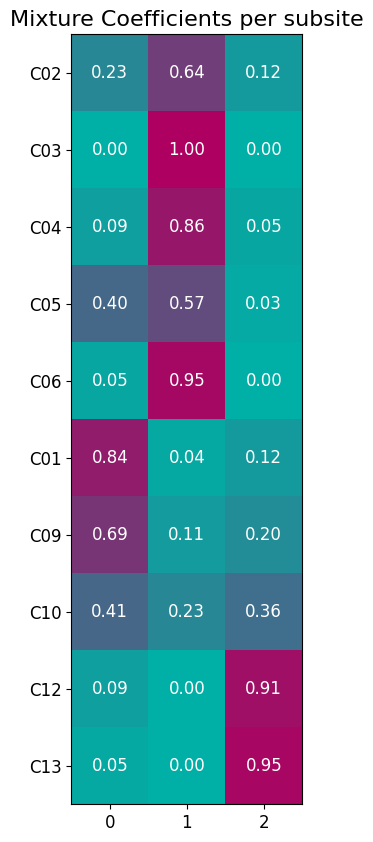

In [33]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap

# USZ colors
usz_blue = '#005ea8'
usz_green = '#00afa5'
usz_red = '#ae0060'
usz_orange = '#f17900'
usz_gray = '#c5d5db'

# colormaps
white_to_blue  = LinearSegmentedColormap.from_list("white_to_blue", 
                                                   ["#ffffff", usz_blue], 
                                                   N=256)
white_to_green = LinearSegmentedColormap.from_list("white_to_green", 
                                                   ["#ffffff", usz_green], 
                                                   N=256)
green_to_red   = LinearSegmentedColormap.from_list("green_to_red", 
                                                   [usz_green, usz_red], 
                                                   N=256)

h = usz_gray.lstrip('#')
gray_rgba = tuple(int(h[i:i+2], 16) / 255. for i in (0, 2, 4)) + (1.0,)
tmp = LinearSegmentedColormap.from_list("tmp", [usz_green, usz_red], N=128)

matrix = mixture.get_mixture_coefs()[['C02', 'C03', 'C04', 'C05', 'C06', 'C01', 'C09', 'C10', 'C12', 'C13']]

# Transpose the matrix to rotate by 90°
matrix_rotated = matrix.T

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 10))

# Display the rotated matrix using imshow
cax = ax.imshow(matrix_rotated.values, cmap=tmp, origin='upper')

# Loop over the data and create text annotations
for i in range(matrix_rotated.shape[0]):  # Rows (previously columns)
    for j in range(matrix_rotated.shape[1]):  # Columns (previously rows)
        value = matrix_rotated.iloc[i, j]
        ax.text(j, i, f"{value:.2f}", ha="center", va="center", 
                color="white", fontsize=12)


# Optional: Set axis labels and title
ax.set_xticks(range(matrix_rotated.shape[1]))
ax.set_xticklabels(matrix.index, fontsize = 12)  # Original row labels
ax.set_yticks(range(matrix_rotated.shape[0]))
ax.set_yticklabels(matrix.columns, fontsize = 12)  # Original column labels
ax.set_title("Mixture Coefficients per subsite", fontsize = 16)
plt.show()


2d Simplex plot

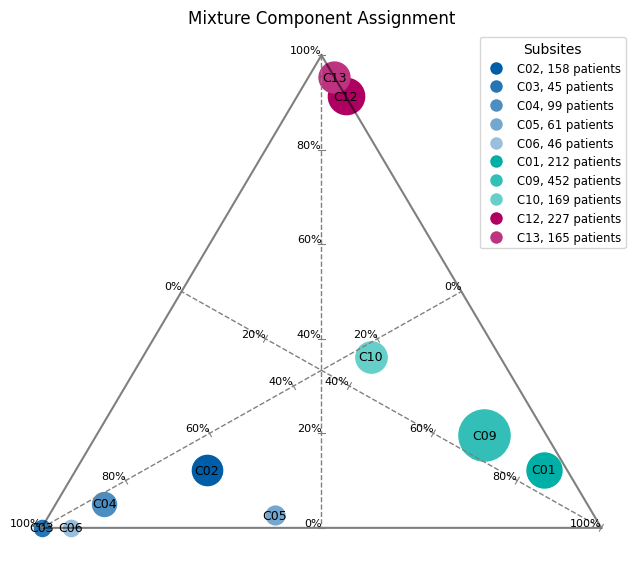

In [29]:
from matplotlib.lines import Line2D
# colormaps
blue_to_white = LinearSegmentedColormap.from_list("blue to white", 
                                                   [usz_blue, "#ffffff"], 
                                                   N=256)
green_to_white = LinearSegmentedColormap.from_list("green_to_white", 
                                                   [usz_green, "#ffffff"], 
                                                   N=256)
red_to_white   = LinearSegmentedColormap.from_list("red_to_white", 
                                                   [usz_red, "#ffffff"], 
                                                   N=256)
orange_to_white   = LinearSegmentedColormap.from_list("orange_to_white", 
                                                   [usz_orange, "#ffffff"], 
                                                   N=256)
colors_ordered= [blue_to_white(0), blue_to_white(0.15), blue_to_white(0.3), blue_to_white(0.45), blue_to_white(0.6), green_to_white(0), green_to_white(0.2), green_to_white(0.4), red_to_white(0), red_to_white(0.2)]  

# Define the plane's normal vector
normal_vector = np.array([1,1,1])/1/np.sqrt(3)

v1 = np.array([1,-1,0])/1/np.sqrt(2)

# Calculate the second orthogonal vector using the cross product
v2 = np.cross(normal_vector, v1) *-1

# Project the point onto the new coordinate system
origin = np.array([0, 1, 0])
x_origin =  origin @ v1
y_origin = origin @ v2

x_vals = matrix.T @ v1 - x_origin
y_vals = matrix.T @ v2 - y_origin

extremes = np.array([[1,0,0],
                    [0,1,0],
                    [0,0,1]])
extremes_x = extremes @ v1 - x_origin
extremes_y = extremes @ v2 - y_origin

# Plot the point in 2D
import matplotlib.pyplot as plt

odered_value_counts = dataset_staging_main_groups['tumor']['1']['subsite'].value_counts()[['C02', 'C03', 'C04', 'C05', 'C06', 'C01', 'C09', 'C10', 'C12', 'C13']]
sizes = odered_value_counts * 3

# Define the subsite labels
subsites = ['C02', 'C03', 'C04', 'C05', 'C06', 'C01', 'C09', 'C10', 'C12', 'C13']
plt.figure(figsize=(8, 6.8))
# Plot the points with varying sizes and colors
for i in range(len(x_vals)):
    plt.scatter(x_vals[i], y_vals[i], s=sizes[i], color=colors_ordered[i], label=subsites[i])
    plt.text(x_vals[i], y_vals[i], subsites[i], fontsize=9, ha='center', va='center')

legend_text = []
for index in range(len(subsites)):
    legend_text.append(subsites[index] + ', ' + str(odered_value_counts[index]) + ' patients')

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=subsite)
                   for color, subsite in zip(colors_ordered, legend_text)]

# Add a legend with fixed dot sizes
plt.legend(handles=legend_elements, loc='upper right', title='Subsites', fontsize='small')
# plt.scatter(x_vals, y_vals, s=sizes, c = colors_ordered)
# Connect the points
plt.plot(extremes_x, extremes_y, color='black', alpha = 0.5)
# close the triangle by connecting the last point to the first
plt.plot([extremes_x[-1], extremes_x[0]], [extremes_y[-1], extremes_y[0]], color='black', alpha = 0.5)

# Calculate midpoints of each side of the triangle
midpoints_x = (extremes_x[0] + extremes_x[1]) / 2, (extremes_x[1] + extremes_x[2]) / 2, (extremes_x[2] + extremes_x[0]) / 2
midpoints_y = (extremes_y[0] + extremes_y[1]) / 2, (extremes_y[1] + extremes_y[2]) / 2, (extremes_y[2] + extremes_y[0]) / 2

# Draw lines from each vertex to the midpoint of the opposite side
plt.plot([extremes_x[0], midpoints_x[1]], [extremes_y[0], midpoints_y[1]], color='gray', linestyle='--', linewidth=1)
plt.plot([extremes_x[1], midpoints_x[2]], [extremes_y[1], midpoints_y[2]], color='gray', linestyle='--', linewidth=1)
plt.plot([extremes_x[2], midpoints_x[0]], [extremes_y[2], midpoints_y[0]], color='gray', linestyle='--', linewidth=1)

# Function to add perpendicular ticks as short lines
def add_perpendicular_ticks(x1, y1, x2, y2, tick_length=0.01):
    num_ticks = 6  # Number of ticks including 0% and 100%
    for i in range(num_ticks):
        t = i / (num_ticks - 1)
        x_tick = x1 + t * (x2 - x1)
        y_tick = y1 + t * (y2 - y1)
        
        # Vector along the line
        dx = x2 - x1
        dy = y2 - y1
        
        # Perpendicular vector
        perp_dx = -dy
        perp_dy = dx
        
        # Normalize the perpendicular vector
        length = np.sqrt(perp_dx**2 + perp_dy**2)
        perp_dx /= length
        perp_dy /= length
        
        # Draw tick as a short perpendicular line
        plt.plot([x_tick - tick_length * perp_dx, x_tick + tick_length * perp_dx], [y_tick - tick_length * perp_dy, y_tick + tick_length * perp_dy], color='gray', linewidth=0.8)
        plt.text(x_tick, y_tick, f'{int(100 - t * 100)}%', fontsize=8, ha='right', va='bottom')

# Add perpendicular ticks to each line with adjusted length
add_perpendicular_ticks(extremes_x[0], extremes_y[0], midpoints_x[1], midpoints_y[1])
add_perpendicular_ticks(extremes_x[1], extremes_y[1], midpoints_x[2], midpoints_y[2])
add_perpendicular_ticks(extremes_x[2], extremes_y[2], midpoints_x[0], midpoints_y[0])



plt.xlabel('u')
plt.ylabel('v')
plt.title('Mixture Component Assignment')
plt.gca().set_axis_off()

plt.show()

In [161]:


legend_text

['C02, 158 patients',
 'C03, 45 patients',
 'C04, 99 patients',
 'C05, 61 patients',
 'C06, 46 patients',
 'C01, 212 patients',
 'C09, 452 patients',
 'C10, 169 patients',
 'C12, 227 patients',
 'C13, 165 patients']